In [1]:
import os
import warnings

import matplotlib
#matplotlib.use('Agg')
from matplotlib import figure  
from matplotlib.backends import backend_agg
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
import seaborn as sns
from natsort import natsorted
from skimage import io
import pandas as pd
from sklearn.base import BaseEstimator,TransformerMixin
from scipy.ndimage.interpolation import zoom
import datetime
import seaborn as sns
tfd = tfp.distributions
import gc

In [2]:
im_dir = 'dicom_images'

In [3]:
train_csv = pd.read_csv('hcomb_train.csv')

In [4]:
class Resize(BaseEstimator,TransformerMixin):
    def __init__(self, output_size):
        assert isinstance(output_size, tuple)
        self.output_size = output_size
        
    def fit(self,X,y=None):
        return self

    def transform(self, samples):
        to_ret = []
        for image in samples:
            
            resize_factor = np.array(self.output_size) / np.array(image.shape)
            image = zoom(image, resize_factor, mode='nearest')
            to_ret.append(
                image    
            )
        return to_ret
    
    def fit_transform(self, samples,y=None):
        to_ret = []
        for image in samples:
            
            resize_factor = np.array(self.output_size) / np.array(image.shape)
            image = zoom(image, resize_factor, mode='nearest')
            to_ret.append(
                image    
            )
        return to_ret

In [5]:
class PreprocessData(BaseEstimator,TransformerMixin):
    #I'm requiring the user to know in advance the values
    #of each categorical variable, since otherwise
    #if a subset of the data is missing a category,
    #the dummy variables will be incorrect
    def __init__(self,numerical_features = [],categorical_encoder = dict(),
                feature_adder = None,
                set_index = None):
        self.numerical_features = numerical_features
        self.categorical_encoder = categorical_encoder
        self.feature_adder = feature_adder
        self.set_index = set_index
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        
        if self.feature_adder:
            X = self.feature_adder(X)
        if self.set_index:
            X = X.set_index(self.set_index)
        cur_df = X.loc[:,self.numerical_features]
        for colname,categories in self.categorical_encoder.items():
            cur_col = X.loc[:,colname].values
            one_hots = np.eye(len(categories))
            cats = {category: one_hots[i] for i,category in enumerate(categories)}
            def get_cat(x):
                return cats.get(x,None)
            
            output_arr = np.vstack([get_cat(x) for x in cur_col])
            
            to_concat = pd.DataFrame(output_arr,index=cur_df.index,columns=categories)
            
            cur_df = pd.concat([cur_df,to_concat],axis=1)
        return cur_df
    
    def fit_transform(self,X,y=None):
        
        if self.feature_adder:
            X = self.feature_adder(X)
        if self.set_index:
            X = X.set_index(self.set_index)
        cur_df = X.loc[:,self.numerical_features]
        for colname,categories in self.categorical_encoder.items():
            cur_col = X.loc[:,colname].values
            one_hots = np.eye(len(categories))
            cats = {category: one_hots[i] for i,category in enumerate(categories)}
            def get_cat(x):
                return cats.get(x,None)
            output_arr = np.vstack([get_cat(x) for x in cur_col])
            to_concat = pd.DataFrame(output_arr,index=cur_df.index,columns=categories)
            cur_df = pd.concat([cur_df,to_concat],axis=1)
        return cur_df

In [6]:
def feature_adder(df):
    new_df = df.copy()
    new_df["TotVol"] = new_df["FVC"]/new_df["Percent"]
    for patient in new_df['Patient']:
        min_week = new_df.loc[df['Patient']==patient,'Weeks'].idxmin()
        new_df.loc[df['Patient']==patient,"Int_Week"] = df.loc[min_week,'Weeks']
        new_df.loc[df['Patient']==patient,"Int_FVC"] = df.loc[min_week,'FVC']
        new_df.loc[df['Patient']==patient,"Int_Perc"] = df.loc[min_week,'Percent']
        
    new_df["Weeks"] = np.minimum(new_df['Weeks'] - new_df['Int_Week'],63)
    
    return new_df
    
preproc = PreprocessData(numerical_features = ["FVC","Weeks",
                                               "Age",
                                               "TotVol",
                                              #"Percent",
                                              #"Int_Week",
                                              "Int_FVC",
                                               #"Int_Perc",
                                              "density",
                                              "HComb",
                                              ],
                        categorical_encoder = {"Sex":["Male","Female"],
                                              "SmokingStatus":["Ex-smoker","Currently smokes","Never smoked"]},
                        feature_adder=feature_adder,
                        set_index="Patient")

In [7]:
resize = Resize((20,64,64,1))

In [8]:
preprocessed_train = preproc.transform(train_csv)

In [9]:
preprocessed_train.head()

,FVC,Weeks,Age,TotVol,Int_FVC,density,HComb,Male,Female,Ex-smoker,Currently smokes,Never smoked
Patient,,,,,,,,,,,,
ID00007637202177411956430,2315,0.0,79,39.74,2315.0,51.892489,19.7,1.0,0.0,1.0,0.0,0.0
ID00007637202177411956430,2214,9.0,79,39.74,2315.0,51.892489,19.7,1.0,0.0,1.0,0.0,0.0
ID00007637202177411956430,2061,11.0,79,39.74,2315.0,51.892489,19.7,1.0,0.0,1.0,0.0,0.0
ID00007637202177411956430,2144,13.0,79,39.74,2315.0,51.892489,19.7,1.0,0.0,1.0,0.0,0.0
ID00007637202177411956430,2069,15.0,79,39.74,2315.0,51.892489,19.7,1.0,0.0,1.0,0.0,0.0


In [10]:
len(preprocessed_train.index)

1549

In [11]:
def get_stacked_image(imList):
    return np.vstack([np.expand_dims(plt.imread(im),0).astype(np.float)
                      for im in imList])

In [12]:
images_dict = {patient_name : resize.transform([get_stacked_image([os.path.join(im_dir,patient_name,im) for im in 
                          natsorted(os.listdir(os.path.join(im_dir,patient_name)))])])
                          for patient_name in os.listdir(im_dir)
                             }

In [13]:
labels = preprocessed_train.loc[:,'FVC']

In [19]:
test = resize.transform([get_stacked_image([os.path.join(im_dir,'ID00426637202313170790466',im) for im in 
                          natsorted(os.listdir(os.path.join(im_dir,'ID00426637202313170790466')))])])[0]

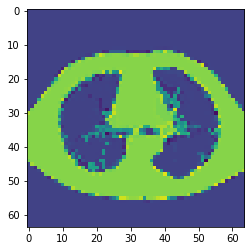

In [20]:
plt.imshow(test[10])

In [ ]:
np.median(labels)

In [14]:
for col in preprocessed_train.columns:
    if col != 'FVC':
        min_val,max_val = preprocessed_train.loc[:,col].min(),preprocessed_train.loc[:,col].max()
        preprocessed_train[col] = (preprocessed_train[col]-min_val)/(max_val-min_val)

In [15]:
data_ims = np.vstack([images_dict[key] for key in preprocessed_train.index])
tabdata = preprocessed_train.drop(columns=['FVC']).values
gc.collect()

60

In [16]:
data_ims.shape

(1549, 20, 64, 64, 1)

In [21]:
IMAGE_SHAPE = [64,64,1]
NUM_TRAIN_EXAMPLES = len(data_ims)
NUM_HELDOUT_EXAMPLES = 40

In [38]:
learning_rate=0.001                
num_epochs = 75
BATCH_SIZE = 20               
data_dir=os.path.join('BayesianNN', 'tmp',
                                         'bayesian_neural_network','data')                  
model_dir=os.path.join('BayesianNN',
                         'bayesian_neural_network')
viz_steps=50
num_monte_carlo=50

In [33]:
def create_model():
    """Creates a Keras model using the LeNet-5 architecture.
    Returns:
      model: Compiled Keras model.
    """
  # KL divergence weighted by the number of training samples, using
  # lambda function to pass as input to the kernel_divergence_fn on
  # flipout layers.
    kl_divergence_function = (lambda q, p, _: tfd.kl_divergence(q, p) /  # pylint: disable=g-long-lambda
                            tf.cast(NUM_TRAIN_EXAMPLES, dtype=tf.float32))

  # Define a LeNet-5 model using three convolutional (with max pooling)
  # and two fully connected dense layers. We use the Flipout
  # Monte Carlo estimator for these layers, which enables lower variance
  # stochastic gradients than naive reparameterization.
    
    #tower 1
    input0 = tf.keras.layers.Input(shape=(20,64,64,1))
    conv0 = tfp.layers.Convolution3DFlipout(
          6, kernel_size=5, padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu)(input0)
    pool0 = tf.keras.layers.MaxPooling3D(
          pool_size=[2, 2,2], strides=[2, 2,2],
          padding='SAME')(conv0)
    conv1 = tfp.layers.Convolution3DFlipout(
          16, kernel_size=5, padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu)(pool0)
    pool1 = tf.keras.layers.MaxPooling3D(
          pool_size=[2, 2,2], strides=[2, 2,2],
          padding='SAME')(conv1)
    conv2 = tfp.layers.Convolution3DFlipout(
          20, kernel_size=5, padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu)(pool1)
    flat1 = tf.keras.layers.Flatten()(conv2)
    dense0 = tfp.layers.DenseFlipout(3)(flat1)
    
    #tower 2
    input1 = tf.keras.layers.Input(shape=(11,))
    dense1 = tfp.layers.DenseFlipout(
          20, kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu)(input1)
    
    #combine towers
    concat = tf.keras.layers.concatenate([dense0,dense1])
    dense2 = tfp.layers.DenseFlipout(
          12, kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu)(concat)
    out = tfp.layers.DenseFlipout(
          1, kernel_divergence_fn=kl_divergence_function)(dense2)
  
    model = tf.keras.Model(inputs=[input0,input1],outputs=out)
  # Model compilation.
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
  # The Keras API will automatically add the
  # Kullback-Leibler divergence (contained on the individual layers of
  # the model), to the mean squared error loss, effectively
  # calcuating the (negated) Evidence Lower Bound Loss (ELBO)
    model.compile(optimizer, loss='mean_squared_error',
                metrics=['mae'], experimental_run_tf_function=False)
    return model

In [26]:
def box_plot(x_list,title,savefile):
    fig = plt.figure()
    plt.title(title)
    plt.xlabel('Categorical Variables')
    plt.ylabel('Predicted FVC')
    sns.boxplot(data=x_list,orient='v')
    plt.savefig(savefile,bbox_inches='tight')
    plt.close()

In [28]:
gc.collect()

20

In [36]:
def main(argv):
    del argv  # unused
    #if tf.io.gfile.exists(model_dir):
    #    tf.compat.v1.logging.warning(
    #    'Warning: deleting old log directory at {}'.format(model_dir))
    #    tf.io.gfile.rmtree(model_dir)
    tf.io.gfile.makedirs(model_dir)
    train_set, heldout_set = (data_ims[:NUM_TRAIN_EXAMPLES],
                              tabdata[:NUM_TRAIN_EXAMPLES],
                              labels[:NUM_TRAIN_EXAMPLES]), (data_ims[-NUM_HELDOUT_EXAMPLES:],
                     tabdata[-NUM_TRAIN_EXAMPLES:],
                     labels[-NUM_HELDOUT_EXAMPLES:])
    train_seq = [(train_set[0][i*BATCH_SIZE:(i+1)*BATCH_SIZE],
                  train_set[1][i*BATCH_SIZE:(i+1)*BATCH_SIZE],
                 train_set[2][i*BATCH_SIZE:(i+1)*BATCH_SIZE])
                 for i in range(0,NUM_TRAIN_EXAMPLES//BATCH_SIZE) ]
    heldout_seq_im =  np.vstack([heldout_set[0][i*BATCH_SIZE:(i+1)*BATCH_SIZE] 
                                 for i in range(0,NUM_HELDOUT_EXAMPLES//BATCH_SIZE)])
    heldout_seq_tab = np.vstack([heldout_set[1][i*BATCH_SIZE:(i+1)*BATCH_SIZE] 
                                 for i in range(0,NUM_HELDOUT_EXAMPLES//BATCH_SIZE)])
                 #heldout_set[2][i*BATCH_SIZE:(i+1)*BATCH_SIZE])
                    
    #print(train_set[0].shape)
    model = create_model()
  
    #model.build(input_shape=[None, BATCH_SIZE, 32, 32, 1])
    losses = []
    print(' ... Training convolutional neural network')
    for epoch in range(num_epochs):
        epoch_accuracy, epoch_loss = [], []
        for step, (batch_x_im,batch_x_tab, batch_y) in enumerate(train_seq):
            batch_loss, batch_accuracy = model.train_on_batch(
          [batch_x_im,batch_x_tab], batch_y)
            epoch_accuracy.append(batch_accuracy)
            epoch_loss.append(batch_loss)

            if (step+1) % BATCH_SIZE == 0:
                print('Epoch: {}, Batch index: {}, '
                      'Loss: {:.3f}, Accuracy: {:.3f}'.format(
                          epoch, step,
                          tf.reduce_mean(epoch_loss),
                          tf.reduce_mean(epoch_accuracy)))

            if (step+1) % viz_steps == 0:
                # Compute log prob of heldout set by averaging draws from the model:
                # p(heldout | train) = int_model p(heldout|model) p(model|train)
                #                   ~= 1/n * sum_{i=1}^n p(heldout | model_i)
                # where model_i is a draw from the posterior p(model|train).
                print(' ... Running monte carlo inference')
                probs = [model.predict([heldout_seq_im,heldout_seq_tab], verbose=0)
                                  for _ in range(num_monte_carlo)]
                
                box_plot(probs,'Predictions',os.path.join('BayesianNN','plots','epoch{}_step{}_pred.png'.format(
                                      epoch, step))) 
        
                                  
            
        losses.append(tf.reduce_mean(epoch_loss))
    plt.figure()
    plt.grid(True)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error (FVC)')
    plt.plot(losses)
    plt.savefig(os.path.join('BayesianNN','plots','MSE.png'),bbox_inches='tight')
    model.save(os.path.join('BayesianNN','bayesian_neural_network'))
    plt.close()
    gc.collect()

In [39]:
main([])

 ... Training convolutional neural network
Epoch: 0, Batch index: 19, Loss: 6319430.500, Accuracy: 2221.205
Epoch: 0, Batch index: 39, Loss: 4900149.000, Accuracy: 1870.785
 ... Running monte carlo inference
Epoch: 0, Batch index: 59, Loss: 4154869.250, Accuracy: 1668.703
Epoch: 1, Batch index: 19, Loss: 2068600.375, Accuracy: 1108.159
Epoch: 1, Batch index: 39, Loss: 2044373.000, Accuracy: 1106.100
 ... Running monte carlo inference
Epoch: 1, Batch index: 59, Loss: 1964709.750, Accuracy: 1058.986
Epoch: 2, Batch index: 19, Loss: 1617486.375, Accuracy: 918.489
Epoch: 2, Batch index: 39, Loss: 1713547.625, Accuracy: 970.362
 ... Running monte carlo inference
Epoch: 2, Batch index: 59, Loss: 1661902.625, Accuracy: 942.229
Epoch: 3, Batch index: 19, Loss: 1522572.125, Accuracy: 892.550
Epoch: 3, Batch index: 39, Loss: 1647170.375, Accuracy: 953.491
 ... Running monte carlo inference
Epoch: 3, Batch index: 59, Loss: 1652450.250, Accuracy: 949.748
Epoch: 4, Batch index: 19, Loss: 1487014.37

Epoch: 36, Batch index: 19, Loss: 480877.062, Accuracy: 419.380
Epoch: 36, Batch index: 39, Loss: 477544.500, Accuracy: 420.760
 ... Running monte carlo inference
Epoch: 36, Batch index: 59, Loss: 479291.406, Accuracy: 420.836
Epoch: 37, Batch index: 19, Loss: 497216.000, Accuracy: 430.726
Epoch: 37, Batch index: 39, Loss: 478717.562, Accuracy: 417.355
 ... Running monte carlo inference
Epoch: 37, Batch index: 59, Loss: 479536.562, Accuracy: 419.494
Epoch: 38, Batch index: 19, Loss: 459448.188, Accuracy: 400.742
Epoch: 38, Batch index: 39, Loss: 437064.656, Accuracy: 393.794
 ... Running monte carlo inference
Epoch: 38, Batch index: 59, Loss: 438563.219, Accuracy: 395.331
Epoch: 39, Batch index: 19, Loss: 484803.344, Accuracy: 430.422
Epoch: 39, Batch index: 39, Loss: 457475.656, Accuracy: 413.162
 ... Running monte carlo inference
Epoch: 39, Batch index: 59, Loss: 448132.000, Accuracy: 406.786
Epoch: 40, Batch index: 19, Loss: 501754.344, Accuracy: 435.799
Epoch: 40, Batch index: 39, 

Epoch: 72, Batch index: 39, Loss: 280233.562, Accuracy: 257.079
 ... Running monte carlo inference
Epoch: 72, Batch index: 59, Loss: 268259.688, Accuracy: 244.666
Epoch: 73, Batch index: 19, Loss: 263470.938, Accuracy: 238.443
Epoch: 73, Batch index: 39, Loss: 287413.531, Accuracy: 268.652
 ... Running monte carlo inference
Epoch: 73, Batch index: 59, Loss: 276405.500, Accuracy: 254.720
Epoch: 74, Batch index: 19, Loss: 273629.938, Accuracy: 253.824
Epoch: 74, Batch index: 39, Loss: 273758.750, Accuracy: 256.501
 ... Running monte carlo inference
Epoch: 74, Batch index: 59, Loss: 267446.062, Accuracy: 247.873
INFO:tensorflow:Assets written to: BayesianNN\bayesian_neural_network\assets


In [41]:
plt.close()
gc.collect()

39